In [71]:
import pandas as pd
import geopandas as gpd
import numpy as np

## Collecting Results of BDistricting

In [72]:
counties = [
    'adams',
    'allegheny',
    'armstrong',
    'beaver',
    'bedford',
    'berks',
    'blair',
    'bradford',
    'bucks',
    'butler',
    'cambria',
    'cameron',
    'carbon',
    'centre',
    'chester',
    'clarion',
    'clearfield',
    'clinton',
    'columbia',
    'crawford',
    'cumberland',
    'dauphin',
    'delaware',
    'elk',
    'erie',
    'fayette',
    'forest',
    'franklin',
    'fulton',
    'greene',
    'huntingdon',
    'indiana',
    'jefferson',
    'juniata',
    'lackawanna',
    'lancaster',
    'lawrence',
    'lebanon',
    'lehigh',
    'luzerne',
    'lycoming',
    'mckean',
    'mercer',
    'mifflin',
    'monroe',
    'montgomery',
    'montour',
    'northampton',
    'northumberland',
    'perry',
    'philadelphia',
    'pike',
    'potter',
    'schuylkill',
    'snyder',
    'somerset',
    'sullivan',
    'susquehanna',
    'tioga',
    'union',
    'venango',
    'warren',
    'washington',
    'wayne',
    'westmoreland',
    'wyoming',
    'york'
]

In [73]:
PA_Bdistrict_out = pd.read_csv('data/PA_Congress.csv')
PA_Bdistrict_out = PA_Bdistrict_out.set_index('FULLCODE')
PA_Bdistrict_out = PA_Bdistrict_out.loc[:, ~PA_Bdistrict_out.columns.str.contains('^Unnamed')]
PA_Bdistrict_out.head()

,DISTRICT
FULLCODE,
420010301011000,4
420010301011001,4
420010301011002,4
420010301011003,4
420010301011004,4


In [74]:
# Define dataframe to carry all PA info
df = pd.DataFrame({'VTD': []})

# Helper function for VTD
def convert_vtd_type(obj):
    if type(obj) is not str:
        return format(int(obj), '06d')
    return obj

for i in range(1, 68):
    # Convert step into county fips string
    num = i*2 - 1
    county_fips = format(num, '03d')
    
    # define dataframe from the census block data from county specified by
    # county_fips
    url = f'https://www2.census.gov/geo/maps/DC2020/PL20/st42_pa/censusblock_maps/c42{county_fips}_{counties[i-1]}/PL20BLK_C42{county_fips}_BLK2MS.txt'
    subdf = pd.read_csv(url, sep=';')
    subdf = subdf.set_index('FULLCODE')

    # Remove useless columns
    subdf = subdf.drop(columns=['TYPE', 'STATE', 'COUNTY','TRACT', 'BLOCK', 'PLACE', 'COUSUB', 'CONCITY', 'AIANHHL', 'SLDU', 'SLDL', 'SHEETS'])
    
    # If VTD is not a string, convert it to one
    subdf['VTD'] = subdf['VTD'].apply(lambda x: convert_vtd_type(x))

    # Concatenate subdf to df
    df = pd.concat([df, subdf])

df.head()

,VTD
420010301011000,000310
420010301011001,000310
420010301011002,000310
420010301011003,000310
420010301011004,000310


In [75]:
# Merging two dataframes
df_final = pd.merge(PA_Bdistrict_out, df, left_index=True, right_index=True)
# Adding column to correspond with GEOID20 in gdf (see section below)
df_final['GEOID20'] = df_final.index.map(lambda s: str(s)[:5]) + df_final['VTD']
df_final.head()

,DISTRICT,VTD,GEOID20
FULLCODE,,,
420010301011000,4,000310,42001000310
420010301011001,4,000310,42001000310
420010301011002,4,000310,42001000310
420010301011003,4,000310,42001000310
420010301011004,4,000310,42001000310


This final dataframe at the end contains four columns:
- `FULLCODE`: a column representing each individual census block,
- `DISTRICT`: a column representing the district to which it belongs to according to the BDistricting algorithm, and
- `VTD`: a column representing which voting district it belongs to
- `GEOID20`: a column which has both the state code, county code, and VTD ID in one string

## Visualizing Voting Districts

In [76]:
# All credit for these Shapefiles goes to the MGGG Redistricting Lab and their collection of repositories where they
# maintain shapefiles for most of the US states
gdf = gpd.read_file('data/PA_pop/PA_pop.shp')

In [77]:
gdf.head()

,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,AMINPOP10,BCVAP19,BPOP19,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry
0,42001000010,185.0,120.0,ABBOTTSTOWN,5.0,000010,42,2.0,001,183.0,...,1.0,0.000000,0.000000,14.0,0.0,865.737199,620.903614,937.0,661.066098,"POLYGON ((664343.521 -31159.417, 664394.941 -3..."
1,42001000020,172.0,151.0,ARENDTSVILLE,6.0,000020,42,3.0,001,178.0,...,5.0,3.857143,7.714286,27.0,0.0,656.233129,518.588957,790.0,559.141982,"POLYGON ((637504.270 -26605.813, 638030.307 -2..."
2,42001000030,98.0,74.0,BENDERSVILLE,1.0,000030,42,2.0,001,103.0,...,7.0,32.352941,38.823529,11.0,0.0,568.033908,392.635336,541.0,472.758530,"POLYGON ((642210.643 -20528.243, 642237.216 -2..."
3,42001000040,554.0,289.0,BERWICK,14.0,000040,42,5.0,001,575.0,...,3.0,70.000000,75.000000,59.0,0.0,2099.817018,1706.445783,2208.0,1880.963042,"MULTIPOLYGON (((664548.709 -30805.093, 664784...."
4,42001000050,215.0,152.0,BIGLERVILLE,3.0,000050,42,7.0,001,231.0,...,1.0,7.153846,14.538462,10.0,0.0,1012.662149,814.375469,1100.0,886.786844,"POLYGON ((642244.314 -26116.364, 642318.415 -2..."


In [78]:
gdf['G16PREDCLI'] # Number of people per voting district who voted for Clinton in 2016

0       119.000000
1       143.000000
2        83.000000
3       257.000000
4       148.000000
           ...    
9173    276.847643
9174    240.013278
9175     92.912557
9176     63.000000
9177     25.000000
Name: G16PREDCLI, Length: 9178, dtype: float64

In [79]:
# Merge gdf and df_final to combine BDistricts output and census data
gdf_final = pd.merge(gdf, df_final, on='GEOID20', how='inner')
gdf_final = gdf_final.drop_duplicates()
gdf_final.head()

,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,BPOP19,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry,DISTRICT,VTD
0,42001000010,185.0,120.0,ABBOTTSTOWN,5.0,000010,42,2.0,001,183.0,...,0.000000,14.0,0.0,865.737199,620.903614,937.0,661.066098,"POLYGON ((664343.521 -31159.417, 664394.941 -3...",4,000010
48,42001000020,172.0,151.0,ARENDTSVILLE,6.0,000020,42,3.0,001,178.0,...,7.714286,27.0,0.0,656.233129,518.588957,790.0,559.141982,"POLYGON ((637504.270 -26605.813, 638030.307 -2...",4,000020
68,42001000030,98.0,74.0,BENDERSVILLE,1.0,000030,42,2.0,001,103.0,...,38.823529,11.0,0.0,568.033908,392.635336,541.0,472.758530,"POLYGON ((642210.643 -20528.243, 642237.216 -2...",4,000030
94,42001000040,554.0,289.0,BERWICK,14.0,000040,42,5.0,001,575.0,...,75.000000,59.0,0.0,2099.817018,1706.445783,2208.0,1880.963042,"MULTIPOLYGON (((664548.709 -30805.093, 664784....",4,000040
143,42001000050,215.0,152.0,BIGLERVILLE,3.0,000050,42,7.0,001,231.0,...,14.538462,10.0,0.0,1012.662149,814.375469,1100.0,886.786844,"POLYGON ((642244.314 -26116.364, 642318.415 -2...",4,000050


In [80]:
gdf_final['area'] = gdf_final.area
gdf_final['area']

0         1.434856e+06
48        2.075181e+06
68        1.170411e+06
94        2.010292e+07
143       1.692140e+06
              ...     
336887    2.213574e+06
336905    4.892537e+06
336937    5.369318e+05
336948    8.410837e+05
336980    4.442498e+05
Name: area, Length: 9688, dtype: float64

<Axes: >

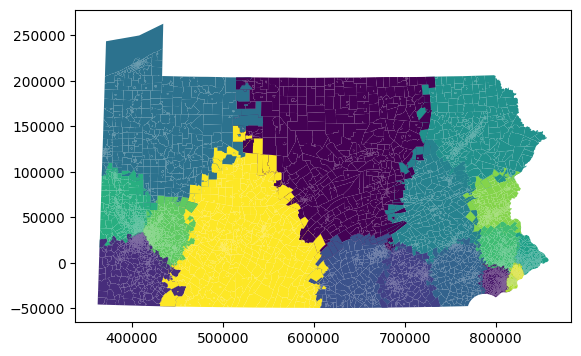

In [81]:
gdf_final.plot(column='DISTRICT')

## Cleaning

In [99]:
gdf_final = gdf_final.rename(columns={'G18GOVRWAG': 'rep_votes_governor18',
                                     'NAME': 'district_name',
                                     'VTDST': 'district_code',
                                     'G18USSRBAR': 'rep_votes_senate18',
                                     'G18USSDCAS': 'dem_votes_senate18',
                                     'G18GOVDWOL':'dem_votes_governor18',
                                     'G16PRERTRU':'rep_votes_president16',
                                     'G16PREDCLI':'dem_votes_president16',
                                     'GEOID20': 'geographic_ID'})

In [100]:
gdf_final

,geographic_ID,rep_votes_governor18,dem_votes_senate18,district_name,G18USSLKER,district_code,STATEFP,G18USSGGAL,COUNTYFP,rep_votes_senate18,...,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry,DISTRICT,VTD,area
0,42001000010,185.000000,120.000000,ABBOTTSTOWN,5.000000,000010,42,2.000000,001,183.000000,...,14.0,0.0,865.737199,620.903614,937.0,661.066098,"POLYGON ((664343.521 -31159.417, 664394.941 -3...",4,000010,1.434856e+06
48,42001000020,172.000000,151.000000,ARENDTSVILLE,6.000000,000020,42,3.000000,001,178.000000,...,27.0,0.0,656.233129,518.588957,790.0,559.141982,"POLYGON ((637504.270 -26605.813, 638030.307 -2...",4,000020,2.075181e+06
68,42001000030,98.000000,74.000000,BENDERSVILLE,1.000000,000030,42,2.000000,001,103.000000,...,11.0,0.0,568.033908,392.635336,541.0,472.758530,"POLYGON ((642210.643 -20528.243, 642237.216 -2...",4,000030,1.170411e+06
94,42001000040,554.000000,289.000000,BERWICK,14.000000,000040,42,5.000000,001,575.000000,...,59.0,0.0,2099.817018,1706.445783,2208.0,1880.963042,"MULTIPOLYGON (((664548.709 -30805.093, 664784....",4,000040,2.010292e+07
143,42001000050,215.000000,152.000000,BIGLERVILLE,3.000000,000050,42,7.000000,001,231.000000,...,10.0,0.0,1012.662149,814.375469,1100.0,886.786844,"POLYGON ((642244.314 -26116.364, 642318.415 -2...",4,000050,1.692140e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336887,42133001426,300.198260,300.097721,YORK WARD 05 PRECINCT 02,10.137585,001426,42,6.123854,133,311.556088,...,55.0,2.0,1223.062201,902.094005,1388.0,997.297181,"POLYGON ((691163.120 -27357.161, 691176.934 -2...",3,001426,2.213574e+06
336905,42133001427,336.493037,250.277567,0,5.647082,0,0,5.083516,0,351.179895,...,54.0,0.0,1500.633002,1155.064166,1741.0,1175.641290,"POLYGON ((693046.190 -25601.872, 693118.825 -2...",3,001427,4.892537e+06
336937,42133001428,130.261246,96.886010,0,2.186066,0,0,1.967902,0,135.946738,...,16.0,0.0,615.308068,453.142793,687.0,453.677989,"MULTIPOLYGON (((696265.771 -28607.067, 696329....",3,001428,5.369318e+05
336948,42133001430,83.000000,61.000000,YORK HAVEN,5.000000,001430,42,3.000000,133,91.000000,...,14.0,0.0,644.000000,430.000000,648.0,510.000000,"POLYGON ((687540.188 -5766.027, 687545.922 -57...",3,001430,8.410837e+05


## Scoring

In [105]:
import fiona
with fiona.open('data/PA_pop/PA_pop.shp') as src:
    print(src.schema['properties'].keys())

dict_keys(['GEOID20', 'G18GOVRWAG', 'G18USSDCAS', 'NAME', 'G18USSLKER', 'VTDST', 'STATEFP', 'G18USSGGAL', 'COUNTYFP', 'G18USSRBAR', 'G18GOVDWOL', 'G18GOVGGLO', 'G18GOVLKRA', 'VTDST20', 'G16TRERVOI', 'NAMELSAD20', 'AWATER20', 'LSAD20', 'G16AUDGSWE', 'NAME20', 'G16AUDRBRO', 'G16PRERTRU', 'G16TRELBAB', 'COUNTYFP20', 'G16TREGCOM', 'G16PREDCLI', 'STATEFP20', 'G16USSRTOO', 'G16PRECCAS', 'G16USSLCLI', 'G16AUDDDEP', 'G16USSDMCG', 'FUNCSTAT20', 'INTPTLAT20', 'G16TREDTOR', 'G16ATGRRAF', 'G16ATGDSHA', 'G16PREGSTE', 'ALAND20', 'G16PRELJOH', 'G16AUDLMIN', 'INTPTLON20', 'VTDI20', 'MTFCC20', 'TOTPOP19', 'TOTPOP10', 'HPOP19', 'HCVAP19', 'HPOP10', 'NHPICVAP19', 'NHCVAP19', 'NHPOP19', 'NHPIPOP19', 'NHPOP10', '2MOREPOP19', '2MORECVAP1', '2MOREPOP10', 'ASIANPOP19', 'ASIANCVAP1', 'ASIANPOP10', 'AMINPOP19', 'AMINCVAP19', 'AMINPOP10', 'BCVAP19', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WCVAP19', 'WPOP10', 'CVAP19'])


### Efficency Gap (EG):
a district is "fair" if two parties waste an equal number of votes (EG = 0). Any votes for a canidate over 50% are considered wasted, and all losing votes are wasted

G18GOVRWAG: Number of votes received by the Republican candidate for governor in the 2018 general election in this voting district.

G18GOVDWOL: Number of votes received by the Democratic candidate for governor in the 2018 general election in this voting district.

In [91]:
all_districts = gdf_final.groupby('GEOID20')
EG_DATA = []
for district, data in all_districts:
    EG_DATA.append((calcEG(data),district))

In [103]:
def calcEG(data):
    # A should be republican
    A_votes = data['G18GOVRWAG'].sum()
    # B should be democrat
    B_votes = data['G18GOVDWOL'].sum()
    total_votes = A_votes + B_votes
    votes_to_win = int(total_votes/2) + 1
    
    # winning party = wasted over 50% 
    wasted_over_50 = max(A_votes,B_votes) - votes_to_win
    
    # losing party = all wasted
    wasted_losing = min(A_votes,B_votes)
    
    if total_votes != 0:
        return(wasted_over_50-wasted_losing)/total_votes
    else:
        return(0)

In [94]:
print(EG_DATA[:2])

[(-0.28852459016393445, '42001000010'), (-0.46686746987951805, '42001000020')]


In [104]:
dem_favored = 0
rep_favored = 0
equal = 0

for d in EG_DATA:
    # dem favored if EG less than 0
    if d[0] < 0:
        dem_favored += 1
    # rep favored if EG greater than 0
    elif d[0] > 0:
        rep_favored += 1   
    elif d[0] == 0:
        equal += 1

print('number dem favored districts: ',dem_favored)
print('number rep favored districts: ',rep_favored)
print('number equal districts: ',equal)

number dem favored districts:  6300
number rep favored districts:  2848
number equal districts:  30


In [106]:
len(EG_DATA)

9178

In [107]:
len(df_final)

336985